# Projet de trading de volatilité
### Master 272 - Ingénierie Economique et Financière
Romain Julian, Amine Mounazil, Emmanuel Zheng

In [113]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
from math import *
from datetime import *
from csv import *
from random import *
import seaborn
import numpy as np

In [114]:
def generate_random_numbers(n):
    d = [random()]
    for i in range(n-1):
        d.append(random())
    return d


def generate_normal_random_numbers(n):
    d = []
    for i in range(n):
        d.append(gauss(0, 1))
        #d.append(-d[2*i])
    return d


def generate_multivar_normal_random_numbers(n, rho):
    d = generate_normal_random_numbers(n*2)
    dout = []
    for i in range(round(d.__len__()/2)):
        dtemp = [0, 0]
        dtemp[0] = d[i]
        dtemp[1] = rho*d[i]+sqrt(1-rho*rho)*d[round(d.__len__()/2)+i]
        dout.append(dtemp)
    return dout


def phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    return (1.0 + erf(x / sqrt(2.0))) / 2.0

In [115]:
class EuropeanCall:
    strike = 100.0
    spot = 100.0
    maturity = 1.0

    def __init__(self, strike, my_underlying, maturity):
        self.strike = strike
        self.spot = my_underlying.spot
        self.maturity = maturity

    def bs_price(self, vol, r):
        d1 = (log(self.spot/self.strike)+self.maturity*(r+vol*vol/2))/(vol*sqrt(self.maturity))
        d2 = d1 - vol*sqrt(self.maturity)
        return phi(d1)*self.spot-phi(d2)*self.strike*exp(-r*self.maturity)

    def bs_delta(self, vol, r):
        d1 = (log(self.spot/self.strike)+self.maturity*(r+vol*vol/2))/(vol*sqrt(self.maturity))
        return phi(d1)

    def montecarlo_price_bs(self, vol, r, nb_simu):
        gauss_sample = generate_normal_random_numbers(nb_simu)
        mc_price = 0
        for rand_spot in gauss_sample:
            spot_sim = self.spot * exp(vol * sqrt(self.maturity) * rand_spot - vol * vol * self.maturity / 2)
            if spot_sim > self.strike:
                mc_price = mc_price + (spot_sim - self.strike) / gauss_sample.__len__()
        return mc_price

    def montecarlo_price_sabr(self, sabr_calib, r, nb_simu, nb_step):
        gauss_sample = generate_multivar_normal_random_numbers(nb_simu*nb_step, sabr_calib.rho)
        price = 0
        i = 1
        sto_vol = sabr_calib.atf_vol
        sto_spot = self.spot
        for rand_spot_vol in gauss_sample:
            ri = sto_vol * sqrt(self.maturity / nb_step) * rand_spot_vol[0] - (pow(sto_vol, 2) * (self.maturity / nb_step)) / 2
            sto_vol = sto_vol + (sqrt(252 * self.maturity / nb_step)) * sabr_calib.daily_alpha * sto_vol * rand_spot_vol[1]
            sto_spot = sto_spot * exp(ri)
            if i % nb_step == 0:
                if sto_spot > self.strike:
                    price = price + sto_spot - self.strike
                sto_vol = sabr_calib.atf_vol
                sto_spot = self.spot
            i = i + 1
        return price / nb_simu

    def bs_imply_vol(self, price, epsilon, r):
        vol_up = 0.2
        vol_down = 0.01
        vol_est = 0.1
        while self.bs_price(vol_up, r) < price:
            vol_down = vol_up
            vol_up = vol_up * 1.2
            vol_est = (vol_up + vol_down) / 2
        while abs(self.bs_price(vol_est, r) - price) > epsilon:
            if (self.bs_price(vol_up, r) - self.bs_price(vol_down, r)) != 0.0:
                vol_est = vol_down + (vol_up - vol_down) * (price - self.bs_price(vol_down, r)) / (
                            self.bs_price(vol_up, r) - self.bs_price(vol_down, r))
            if self.bs_price(vol_est, r) < price:
                vol_down = vol_est
            else:
                vol_up = vol_est
        return vol_est

In [116]:
class EuropeanPut:
    strike = 100.0
    spot = 100.0
    maturity = 1.0

    def __init__(self, strike, my_underlying, maturity):
        self.strike = strike
        self.spot = my_underlying.spot
        self.maturity = maturity

    def bs_price(self, vol, r):
        if self.maturity == 0:
            return max(self.strike - self.spot,0)
        else:
            d1 = (log(self.spot / self.strike) + self.maturity * (r + vol * vol / 2)) / (vol * sqrt(self.maturity))
            d2 = d1 - vol * sqrt(self.maturity)
            return phi(-d2) * self.strike * exp(-r * self.maturity) - phi(-d1) * self.spot

    def bs_delta(self, vol, r):
        if self.maturity == 0:
            if self.spot > self.strike:
                return 0
            else:
                return 1
        else:
            d1 = (log(self.spot/self.strike)+self.maturity*(r+vol*vol/2))/(vol*sqrt(self.maturity))
            return phi(d1)-1

    def bs_imply_vol(self, price, epsilon, r):
        vol_up = 0.2
        vol_down = 0.01
        vol_est = 0.2
        while self.bs_price(vol_up, r) < price:
            vol_down = vol_up
            vol_up = vol_up*1.2
            vol_est = (vol_up + vol_down) / 2
        while abs(self.bs_price(vol_est, r) - price) > epsilon:
            if (self.bs_price(vol_up, r) - self.bs_price(vol_down, r)) != 0.0:
                vol_est = vol_down + (vol_up-vol_down)*(price-self.bs_price(vol_down, r))/(self.bs_price(vol_up, r)-self.bs_price(vol_down, r))
            if self.bs_price(vol_est, r)< price:
                vol_down = vol_est
            else:
                vol_up = vol_est
        return vol_est

    def montecarlo_price_bs(self, vol, r, nb_simu):
        gauss_sample = generate_normal_random_numbers(nb_simu)
        mc_price = 0
        for rand_spot in gauss_sample:
            spot_sim = self.spot * exp(vol * sqrt(self.maturity) * rand_spot - vol * vol * self.maturity / 2)
            if spot_sim < self.strike:
                mc_price = mc_price - (spot_sim - self.strike) / gauss_sample.__len__()
        return mc_price

    def montecarlo_price_sabr(self, sabr_calib, r, nb_simu, nb_step):
        gauss_sample = generate_multivar_normal_random_numbers(nb_simu * nb_step, sabr_calib.rho)
        price = 0
        i = 1
        sto_vol = sabr_calib.atf_vol
        sto_spot = self.spot
        for rand_spot_vol in gauss_sample:
            ri = sto_vol * sqrt(self.maturity / nb_step) * rand_spot_vol[0] - (pow(sto_vol, 2)*(self.maturity / nb_step)) / 2
            sto_vol = sto_vol + (sqrt(252 * self.maturity / nb_step)) * sabr_calib.daily_alpha * sto_vol * \
                      rand_spot_vol[1]
            sto_spot = sto_spot * exp(ri)
            if i % nb_step == 0:
                if sto_spot < self.strike:
                    price = price - sto_spot + self.strike
                sto_vol = sabr_calib.atf_vol
                sto_spot = self.spot
            i = i + 1
        return price / nb_simu

In [117]:
def import_histo_prices_csv(path):
    """
    Function to import historical data from CSV
    :param path:
    :return: historical_prices
    """
    historical_prices = []
    csv_file = open(path)
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for row in csv_reader:
        price_array = []
        if i != 0:
            for price in row:
                price_array.append(float(price))
            historical_prices.append(price_array)
        i = i+1
    return historical_prices

In [118]:
class Underlying:
    spot = 100.0
    ticker = "BNP"

    def __init__(self, spot, ticker):
        self.spot = spot
        self.ticker = ticker

# Butterfly spread option strategy with puts

In [160]:
def put_payoff (sT, strike_price, premium): 
    return np.where(sT< strike_price, strike_price-sT, 0)-premium

# Stock price
spot_price = 123.40

# Long put
higher_strike_price_long_put = 105
higher_premium_long_put = 6.25

lower_strike_price_long_put = 95
lower_premium_long_put = 1.25

# Short put
strike_price_short_put = 100
premium_short_put = 3.15

# Stock price range at expiration of the put
sT = np.arange(0.5*spot_price,2*spot_price,1)

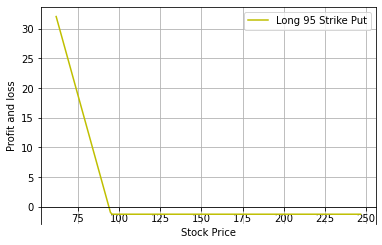

In [161]:
#Point A
payoff_lower_long_put = put_payoff(sT, lower_strike_price_long_put, lower_premium_long_put)

fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_lower_long_put,label='Long 95 Strike Put',color='y')
plt.xlabel('Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.grid()
plt.show()

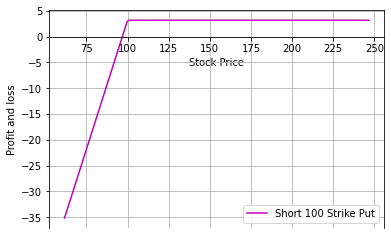

In [162]:
#Point B
payoff_short_put = put_payoff(sT, strike_price_short_put, premium_short_put) * -1.0
fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_short_put,label='Short 100 Strike Put',color='m')
plt.xlabel('Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.grid()
plt.show()

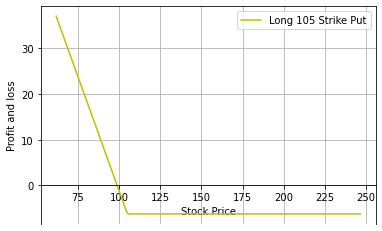

In [163]:
#Point C
payoff_higher_long_put = put_payoff(sT, higher_strike_price_long_put, higher_premium_long_put)

fig, ax = plt.subplots()

ax.spines['bottom'].set_position('zero')

ax.plot(sT,payoff_higher_long_put,label='Long 105 Strike Put',color='y')

plt.xlabel('Stock Price')

plt.ylabel('Profit and loss')

plt.legend()

plt.grid()

plt.show()

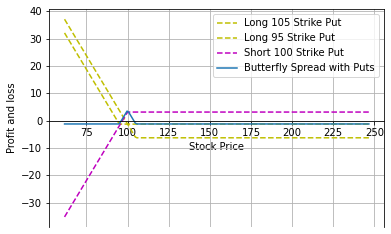

In [164]:
payoff =  payoff_higher_long_put + 2 * payoff_short_put + payoff_lower_long_put
fig, ax = plt.subplots()

ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_higher_long_put,'--',label='Long 105 Strike Put',color='y')
ax.plot(sT,payoff_lower_long_put,'--',label='Long 95 Strike Put',color='y')
ax.plot(sT,payoff_short_put,'--',label='Short 100 Strike Put',color='m')
ax.plot(sT,payoff,label='Butterfly Spread with Puts')
plt.xlabel('Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.grid()
plt.show()

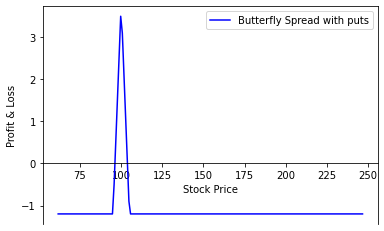

In [165]:
# Payoff Butterfly with puts
Butterfly_spread_payoff_with_puts = payoff_higher_long_put + 2 * payoff_short_put + payoff_lower_long_put
fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(sT,Butterfly_spread_payoff_with_puts ,color='b', label= 'Butterfly Spread with puts')
plt.legend()
plt.xlabel('Stock Price')
plt.ylabel('Profit & Loss')
plt.show()

In [166]:
profit = max(Butterfly_spread_payoff_with_puts)
loss = min(Butterfly_spread_payoff_with_puts)
print ("%.2f" %profit)
print ("%.2f" %loss)

3.50
-1.20


# BONUS - Simulation of a Butterfly Spread with calls

In [167]:
def call_payoff (sT, strike_price, premium):
    return np.where(sT > strike_price, sT - strike_price, 0) - premium

def put_payoff (sT, strike_price, premium): 
    return np.where(sT < strike_price, strike_price - sT, 0) - premium

# Spot Price
s0 = 140

# Long Call
higher_strike_price_long_call = 135
premium_higher_strike_long_call = 0.85

lower_strike_price_long_call= 130
premium_lower_strike_long_call = 3.15

# Short Call
strike_price_short_call = 132.5
premium_short_call = 1.80

# Long put
strike_price_long_put = 280
premium_long_put = 1.20

# Short put
strike_price_short_put = 300
premium_short_put = 3.40

# Range of call option at expiration
sT = np.arange(90,170,1)

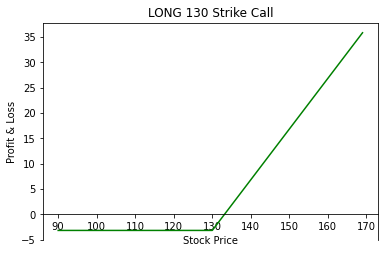

In [168]:
# OTM Strike Long Call Payoff
# Point A
lower_strike_long_call_payoff = call_payoff(sT, lower_strike_price_long_call, premium_lower_strike_long_call)

fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(sT,lower_strike_long_call_payoff, color='g')
ax.set_title('LONG 130 Strike Call')
plt.xlabel('Stock Price')
plt.ylabel('Profit & Loss')
plt.show()

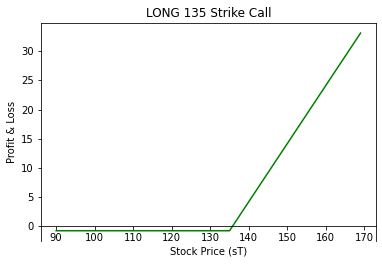

In [169]:
# Higher Strike Long Call Payoff
# Point C
higher_strike_long_call_payoff = call_payoff(sT, higher_strike_price_long_call, premium_higher_strike_long_call)

fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(sT,higher_strike_long_call_payoff, color='g')
ax.set_title('LONG 135 Strike Call')
plt.xlabel('Stock Price (sT)')
plt.ylabel('Profit & Loss')
plt.show()

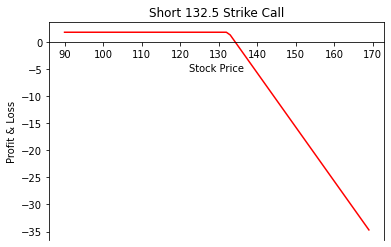

In [170]:
# Short Call Payoff
#Point B
Short_call_payoff = call_payoff(sT, strike_price_short_call, premium_short_call)*-1.0

fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(sT, Short_call_payoff, color='r')
ax.set_title('Short 132.5 Strike Call')
plt.xlabel('Stock Price')
plt.ylabel('Profit & Loss')
plt.show()

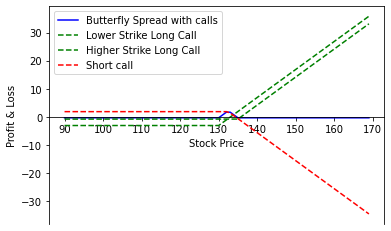

In [171]:
Butterfly_spread_payoff = lower_strike_long_call_payoff + higher_strike_long_call_payoff + 2 *Short_call_payoff

fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(sT,Butterfly_spread_payoff ,color='b', label= 'Butterfly Spread with calls')
ax.plot(sT, lower_strike_long_call_payoff,'--', color='g',label='Lower Strike Long Call')
ax.plot(sT, higher_strike_long_call_payoff,'--', color='g', label='Higher Strike Long Call')
ax.plot(sT, Short_call_payoff, '--', color='r', label='Short call')
plt.legend()
plt.xlabel('Stock Price')
plt.ylabel('Profit & Loss')
plt.show()

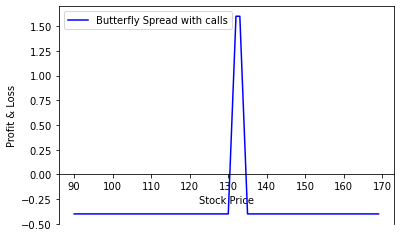

In [172]:
Butterfly_spread_payoff = lower_strike_long_call_payoff + higher_strike_long_call_payoff + 2 * Short_call_payoff
fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(sT,Butterfly_spread_payoff ,color='b', label= 'Butterfly Spread with calls')
plt.legend()
plt.xlabel('Stock Price')
plt.ylabel('Profit & Loss')
plt.show()

In [173]:
profit = max(Butterfly_spread_payoff)
loss = min(Butterfly_spread_payoff)
print ("%.2f" %profit)
print ("%.2f" %loss)

1.60
-0.40


# Simulation : BNP historical data

In [174]:
class Strategy:
    """
    Class containing our strategy/ies
    """
    def __init__(self, path, dividend, cancelation_date, threshold):
        self.path = path
        self.dividend = dividend
        self.cancelation_date = cancelation_date
        self.threshold = threshold
        
    def backtest(self):
        """
        Method to backtest and return the pnl
        :return: pnl
        """
        historical_prices = import_histo_prices_csv(self.path)
        pnl = []
        j = 0
        while j <= historical_prices.__len__() - 200:
            if pd.Series([row[1] for row in historical_prices]).rolling(min_periods=1, window=5).mean()[j] < self.threshold:
                new_histo = [row[:] for row in historical_prices][j:-1]
                pnl.extend(self.butterfly(new_histo)) 
                # 20 jours de non-observation
                j = j + 60
        return pnl
        
    def butterfly(self, historical_prices):   
        """
        Method to price butterfly strategy and return the pnl
        :param historical_prices:
        :return: pnl
        """
        strike = historical_prices[0][1] - self.dividend
        put_underlying = Underlying(strike, "BNP") 
        
        put_A = EuropeanPut(0.9 * strike, put_underlying, (60 / 252))
        put_B = EuropeanPut(strike, put_underlying, (60 / 252))
        put_C = EuropeanPut(1.1 * strike, put_underlying, (60 / 252))
        
        pnl = []
        i = 0
        
        price_A = put_A.bs_price(historical_prices[0][2]/100, 0)
        price_B = put_B.bs_price(historical_prices[0][2]/100, 0)
        price_C = put_C.bs_price(historical_prices[0][2]/100, 0)
        
        price = price_A - 2*price_B + price_C
        
        pnl_t = 0
        pnl.append(pnl_t)
        
        # 20 jours
        for row in range(60):
            if i > 0:
                  
                # Attribution de la maturité à la classe
                put_A.maturity = (60 - i - 1) / 252
                put_B.maturity = (60 - i - 1) / 252
                put_C.maturity = (60 - i - 1) / 252
                
                # Mise à jour du spot
                put_underlying.spot = historical_prices[i][1] - self.dividend
                
                if i > self.cancelation_date:
                    put_underlying.spot = historical_prices[i][1]
                    
                old_price = price
                
                # Reinstanciation et repricing (IV)            
                put_A = EuropeanPut(put_A.strike, put_underlying, put_A.maturity)
                put_B = EuropeanPut(put_B.strike, put_underlying, put_B.maturity)
                put_C = EuropeanPut(put_C.strike, put_underlying, put_C.maturity)
                
                price_A = put_A.bs_price(historical_prices[i][2]/100, 0)
                price_B = put_B.bs_price(historical_prices[i][2]/100, 0)
                price_C = put_C.bs_price(historical_prices[i][2]/100, 0)
        
                price = price_A - 2*price_B + price_C
                
                # (dPrime = price - old_price)
                pnl_t = pnl_t + price - old_price 
                pnl.append(pnl_t)
                
                # debug
                if i == 2230:
                    pass
                
            i = i + 1
        
        return pnl

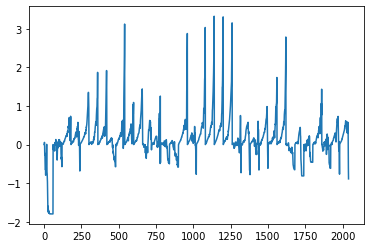

In [175]:
if __name__ == '__main__':
    # Parameters : change the path to read the csv file
    path = 'C:/Users/emman/Documents/TDV_Projet/BNP.csv'
    #path = r'BNP.csv'
    dividend = 0
    cancelation_date = 45

    # Run Strategy
    my_strat = Strategy(path, dividend, cancelation_date, 50)
    pnl = my_strat.backtest()

    # Plot Strategy
    plt.plot(pnl)
    plt.show()

In [176]:
pnl

[0,
 0.011708401617021025,
 0.05638166846393,
 -0.05090354983751855,
 -0.2686119316351856,
 -0.2299161752871528,
 -0.4478112224390558,
 -0.6404951035011068,
 -0.6379335838551334,
 -0.6639272284585154,
 -0.7934699053874024,
 -0.6642874126762277,
 -0.6852314890983882,
 -0.5698358734849569,
 -0.560121501122868,
 -0.1546345474685593,
 -0.04185338523756954,
 0.005476624803434582,
 -0.39710963498573726,
 -0.7086072119983342,
 -0.7581139144149383,
 -0.8669516643499406,
 -0.9721356470539106,
 -1.2580257569215227,
 -1.4264886617777819,
 -1.7060194289550665,
 -1.6547284001510185,
 -1.5991333250180269,
 -1.754355365466079,
 -1.697615366677475,
 -1.761920814784741,
 -1.740900433042853,
 -1.7810251909447992,
 -1.772383438940352,
 -1.781875734900943,
 -1.7936090358062735,
 -1.7936912905721094,
 -1.792142511341595,
 -1.7898434130711074,
 -1.7932965675496035,
 -1.7971401808948109,
 -1.7977028876463663,
 -1.7977752893736607,
 -1.7977927445145276,
 -1.7977988268778837,
 -1.7977992214170122,
 -1.79779898